## 🚦 Traffic Light Detection | Tensorflow

In [36]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import style
style.use('ggplot')
from tqdm import tqdm
from dataclasses import dataclass
import re

📦 Data Set:
 - LISA Traffic Light Dataset - 🚀
 - It has more than 44 minutes of annotated traffic light data.

## 1. Load Data

In [3]:
@dataclass
class AllPath:
    """Class for keeping track of an item in inventory."""
    _DATA_BASE_DIR:pathlib.Path = pathlib.Path('dataset')
    _DATA_ANOTATIONs:pathlib.Path  = _DATA_BASE_DIR / 'Annotations' / 'Annotations'
    DATA_ANOTATIONs_DAY_TRAIN:pathlib.Path = _DATA_ANOTATIONs / 'dayTrain'
    DATA_ANOTATIONs_NIGHT_TRAIN:pathlib.Path = _DATA_ANOTATIONs / 'nightTrain'
    DATA_FILE_LOCATION_DAY_TRAIN:pathlib.Path = _DATA_BASE_DIR / 'dayTrain' / 'dayTrain'
    DATA_FILE_LOCATION_NIGHT_TRAIN:pathlib.Path = _DATA_BASE_DIR / 'nightTrain' / 'nightTrain'
all_paths = AllPath()
all_paths

AllPath(_DATA_BASE_DIR=WindowsPath('dataset'), _DATA_ANOTATIONs=WindowsPath('dataset/Annotations/Annotations'), DATA_ANOTATIONs_DAY_TRAIN=WindowsPath('dataset/Annotations/Annotations/dayTrain'), DATA_ANOTATIONs_NIGHT_TRAIN=WindowsPath('dataset/Annotations/Annotations/nightTrain'), DATA_FILE_LOCATION_DAY_TRAIN=WindowsPath('dataset/dayTrain/dayTrain'), DATA_FILE_LOCATION_NIGHT_TRAIN=WindowsPath('dataset/nightTrain/nightTrain'))

In [4]:
day_train = []
night_train = []

for clip in tqdm(all_paths.DATA_ANOTATIONs_DAY_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    day_train.append(df)


for clip in tqdm(all_paths.DATA_ANOTATIONs_NIGHT_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    night_train.append(df)

df_day_train = pd.concat(day_train)
df_day_train['isNight'] = 0


df_night_train = pd.concat(night_train)
df_night_train['isNight'] = 1

df = pd.concat([df_day_train,df_night_train])
print('All Day and Night training data shap:',df.shape)
df.head()

13it [00:00, 74.22it/s]
5it [00:00, 50.75it/s]

All Day and Night training data shap: (51826, 11)


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


## 2. Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51826 entries, 0 to 3235
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Filename                   51826 non-null  object
 1   Annotation tag             51826 non-null  object
 2   Upper left corner X        51826 non-null  int64 
 3   Upper left corner Y        51826 non-null  int64 
 4   Lower right corner X       51826 non-null  int64 
 5   Lower right corner Y       51826 non-null  int64 
 6   Origin file                51826 non-null  object
 7   Origin frame number        51826 non-null  int64 
 8   Origin track               51826 non-null  object
 9   Origin track frame number  51826 non-null  int64 
 10  isNight                    51826 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.7+ MB


In [6]:
# drop duplicate columns
df = (
    df
    .T # transpose 
    .drop_duplicates() # drop duplicate rows
    .T # transpose back again
    )
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0
...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1


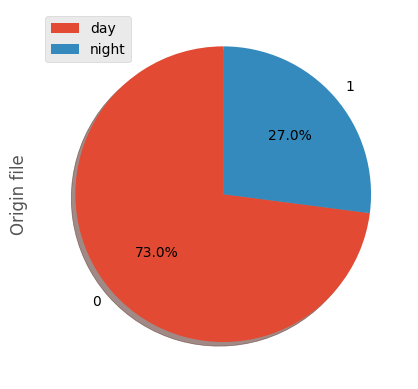

In [7]:
(
    df
    .groupby(by='isNight')
    .count()
    ['Origin file']
    .plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
)
plt.legend(['day', 'night'])

In [8]:
df['Filename']

0           dayTraining/dayClip1--00000.jpg
1           dayTraining/dayClip1--00000.jpg
2           dayTraining/dayClip1--00001.jpg
3           dayTraining/dayClip1--00001.jpg
4           dayTraining/dayClip1--00002.jpg
                       ...                 
3231    nightTraining/nightClip5--01450.jpg
3232    nightTraining/nightClip5--01451.jpg
3233    nightTraining/nightClip5--01451.jpg
3234    nightTraining/nightClip5--01452.jpg
3235    nightTraining/nightClip5--01452.jpg
Name: Filename, Length: 51826, dtype: object

In [9]:
def changFileName(x):
    """
    An helper function to change file name 
    i.e. 
    dayTraining/dayClip1--00000.jpg -> 
    dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg
    """

    
    file_name = re.findall("^.*/(.*)",x.Filename)[0]
    dayClip = file_name.split('--')[0]
    
    if x.isNight == 1:
        return str(all_paths.DATA_FILE_LOCATION_NIGHT_TRAIN \
            / dayClip \
            / 'frames' \
            / file_name)
    
    elif x.isNight == 0:
        return str(all_paths.DATA_FILE_LOCATION_DAY_TRAIN \
            / dayClip \
            / 'frames' \
            / file_name)


df['CorrectFileLocation'] = df.apply(changFileName,axis=1)
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight,CorrectFileLocation
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...
...,...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1,dataset\nightTrain\nightTrain\nightClip5\frame...
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1,dataset\nightTrain\nightTrain\nightClip5\frame...
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1,dataset\nightTrain\nightTrain\nightClip5\frame...
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1,dataset\nightTrain\nightTrain\nightClip5\frame...


## data analysis

Text(0, 0.5, '')

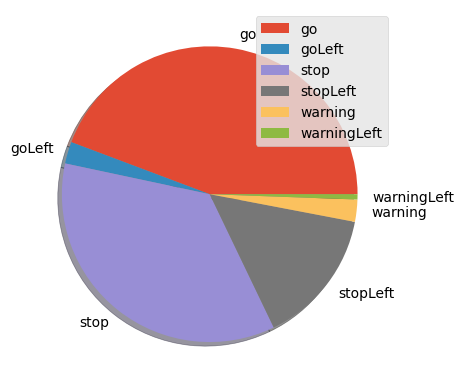

In [10]:
# plot the annotation distribution
(
    df.
    groupby('Annotation tag').
    count()['Origin file'].
    plot.
    pie(shadow=True)
)


plt.legend(
    df.
    groupby('Annotation tag').
    count()['Origin file'].index
    )
plt.ylabel('')

In [11]:
# create label
labels = {'go':0, 'warning':1, 'stop': 2}



df['Annotation tag'].apply(lambda x :0 if 'go' in x else x)

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return labels['go']
    elif 'warning' in x['Annotation tag']:
        return labels['warning']
    elif 'stop' in x['Annotation tag']:
        return labels['stop']

df['label'] = df.apply(changeAnnotation,axis=1)
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight,CorrectFileLocation,label
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,0
...,...,...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1,dataset\nightTrain\nightTrain\nightClip5\frame...,0
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1,dataset\nightTrain\nightTrain\nightClip5\frame...,0
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1,dataset\nightTrain\nightTrain\nightClip5\frame...,0
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1,dataset\nightTrain\nightTrain\nightClip5\frame...,0


Text(0, 0.5, '')

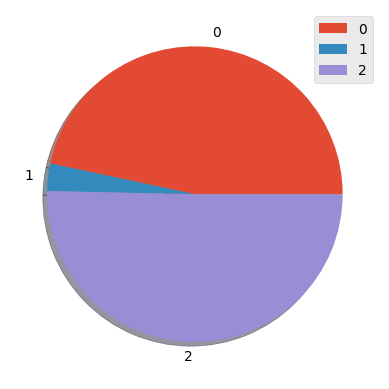

In [15]:
(
    df.
    groupby('label').
    count()['Origin file'].
    plot.
    pie(shadow=True)
)


plt.legend(
    df.
    groupby('label').
    count()['Origin file'].index
    )

plt.ylabel('')

In [44]:
dataset = df[[
       'CorrectFileLocation', 
       'Upper left corner X',
       'Upper left corner Y', 
       'Lower right corner X', 
       'Lower right corner Y',
       'Origin frame number', 
       'isNight',
       'label'
]]

(
       dataset.rename(
              {
                  'CorrectFileLocation' : 'image_id',
                     'Upper left corner X': 'x_min',
                     'Upper left corner Y':'y_min', 
                     'Lower right corner X':'x_max', 
                     'Lower right corner Y':'y_max',
                     'Origin frame number':'frame', 
              }
       ,axis=1
       ,inplace=True
       )
)
dataset.head()

C:\Users\Noel\AppData\Local\Temp\ipykernel_28620\1468594659.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.rename(


,image_id,x_min,y_min,x_max,y_max,frame,isNight,label
0,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,698,333,710,358,0,0,0
1,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,846,391,858,411,0,0,0
2,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,698,337,710,357,1,0,0
3,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,847,390,859,410,1,0,0
4,dataset\dayTrain\dayTrain\dayClip1\frames\dayC...,698,331,710,356,2,0,0


## Exploratory Data Analysis

In [26]:
print("Number of Unique Images: ",dataset.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


C:\Users\Noel\AppData\Local\Temp\ipykernel_28620\3394372855.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.labels = {'go':0, 'warning':1, 'stop': 2}


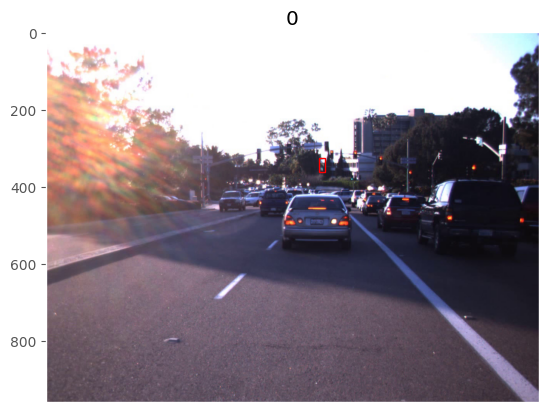

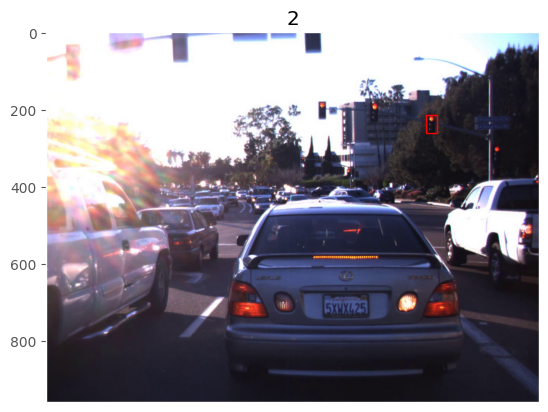

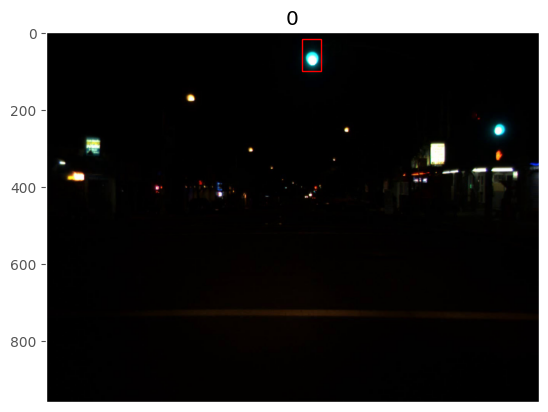

In [125]:
class MyDataset(pd.DataFrame):
    
    def __init__(self,dataset):
        super(MyDataset, self).__init__(dataset)
        self.labels = {'go':0, 'warning':1, 'stop': 2}    
    
    @property
    def _constructor(self):
        return MyDataset

    def image2Array(self,idx):
        return plt.imread(self.iloc[idx].image_id)
    
    def get_label(self,idx):
        return self.iloc[idx].label

    def getObjectCoordination(self,idx):
        x_min = self.iloc[idx].x_min
        x_max = self.iloc[idx].x_max
        y_min = self.iloc[idx].y_min
        y_max = self.iloc[idx].y_max
        return x_min,y_min,x_max-x_min,y_max-y_min

    def showImage(self,idx,*args,**kargs):
        _, ax = plt.subplots(*args,**kargs)
        img = self.image2Array(idx)
        ax.imshow(img)
        ax.grid(False)
        plt.show()

    def plotDetection(self,idx,*args,**kargs):
        x_min,y_min,width,height = self.getObjectCoordination(idx)
        img = self.image2Array(idx)
        _, ax = plt.subplots(*args,**kargs)  
        rect = patches.Rectangle(
        (x_min, y_min),
        height=height,
        width=width,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
        )
        ax.imshow(img)
        ax.add_patch(rect)
        ax.grid(False)
        plt.title(self.get_label(idx))

        plt.show()


MyDataset(dataset).plotDetection(334)
MyDataset(dataset).plotDetection(3333)
MyDataset(dataset).plotDetection(45555)